In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize data to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images (28x28 to 784)
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3824 - val_loss: 0.1909
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1809 - val_loss: 0.1542
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1497 - val_loss: 0.1341
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1317 - val_loss: 0.1212
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1200 - val_loss: 0.1128
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1124 - val_loss: 0.1069
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1071 - val_loss: 0.1026
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1032 - val_loss: 0.0994
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1001 - val_loss: 0.0972
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0982 - val_loss: 0.0957
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0968 - val_loss: 0.0947
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

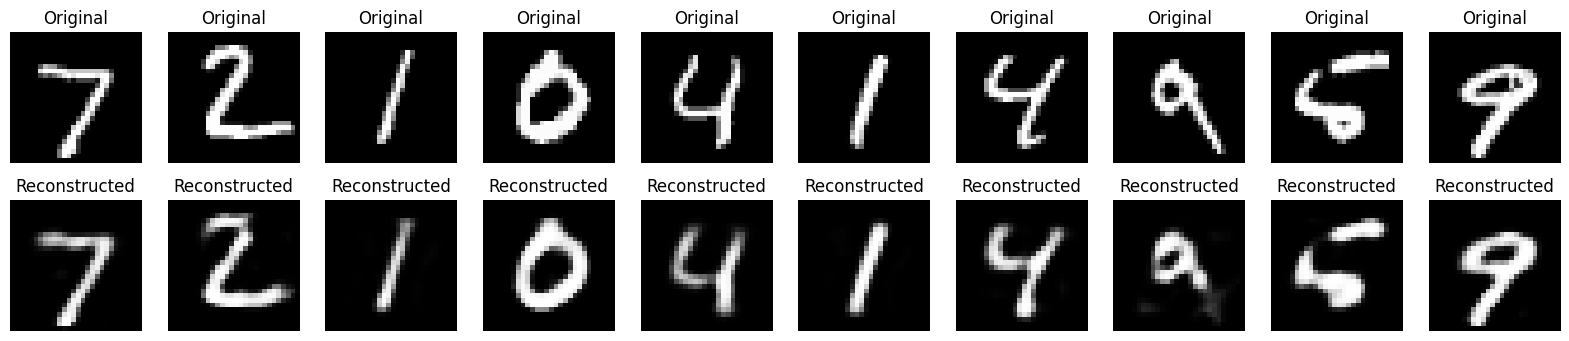

In [2]:
# Define the size of the latent space
encoding_dim = 32  # Compression factor: 784 -> 32

# Build the autoencoder
# Input layer
input_img = Input(shape=(784,))

# Encoder
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Decoder
decoded = Dense(784, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_img, decoded)

# Encoder model (for compressed representations)
encoder = Model(input_img, encoded)

# Decoder model (for reconstruction from latent space)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1](encoded_input)
decoder = Model(encoded_input, decoder_layer)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# Encode and decode some test images
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Visualize original and reconstructed images
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

In [4]:
!pip install torchvision

You should consider upgrading via the 'C:\Users\ajinf\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Device configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 28 * 28  # MNIST images are 28x28
hidden_size = 128     # Size of the latent space
learning_rate = 1e-4
num_epochs = 10
batch_size = 64

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Flatten input
        x = x.view(-1, input_size)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.to(device)
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, data.view(-1, input_size))  # Compare reconstruction with original data
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), 'autoencoder.pth')

print("Training completed!")

Epoch [1/10], Loss: 0.9210
Epoch [2/10], Loss: 0.9094
Epoch [3/10], Loss: 0.8902
Epoch [4/10], Loss: 0.8807
Epoch [5/10], Loss: 0.8756
Epoch [6/10], Loss: 0.8713
Epoch [7/10], Loss: 0.8618
Epoch [8/10], Loss: 0.8557
Epoch [9/10], Loss: 0.8609
Epoch [10/10], Loss: 0.8646
Training completed!


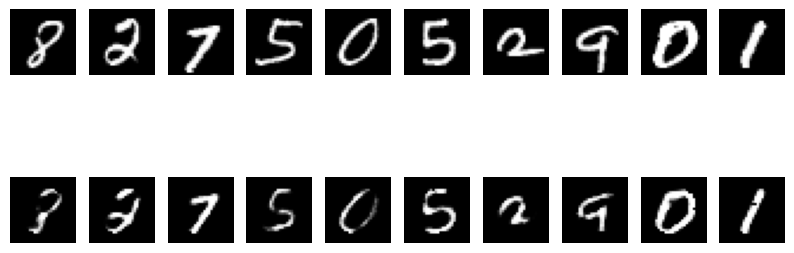

In [17]:
import matplotlib.pyplot as plt

# Test the model on some data
model.eval()
test_data, _ = next(iter(train_loader))
test_data = test_data.to(device)
with torch.no_grad():
    reconstructed = model(test_data)

# Plot original and reconstructed images
n = 10
fig, axes = plt.subplots(2, n, figsize=(10, 4))
for i in range(n):
    # Original images
    axes[0, i].imshow(test_data[i].cpu().view(28, 28), cmap='gray')
    axes[0, i].axis('off')
    # Reconstructed images
    axes[1, i].imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()